In [1]:
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

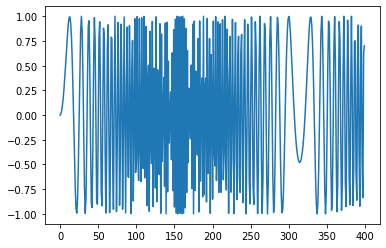

In [2]:
#Generating synthetic data of the form sin(kt^2)
series = np.sin((0.1*np.arange(400))**2)

# plot it
plt.plot(series)
plt.show()

In [3]:
# Building our dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


In [4]:
#Autoregressive linear model
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)

model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.01),
)

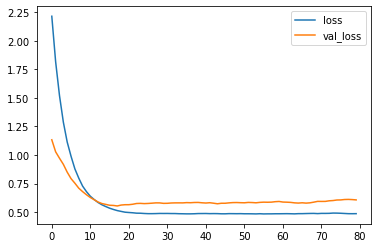

In [5]:
# train the model
r = model.fit(
  X[:N//2], Y[:N//2],
  epochs=80,
  validation_data=(X[N//2:], Y[N//2:]),
  verbose=0,
)

# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

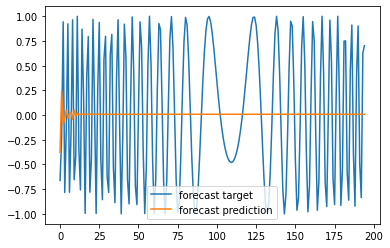

In [6]:
# Forecasting future values
validation_target = Y[N//2:]
validation_predictions = []

# first validation input
last_x = X[N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [16]:
# RNN/LSTM/GRU model
# let's reshape the data
X = X.reshape(-1, T, 1) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))

# Change between these lines to to try RNN/LSTM/GRU model
# x = SimpleRNN(10)(i) 
# x = LSTM(10)(i)
x = GRU(10)(i)

x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.05),
)

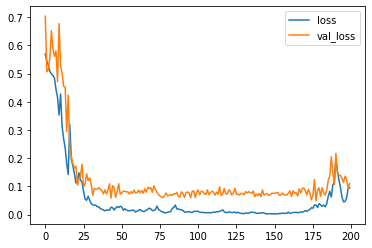

In [14]:
# train with the simple RNN
r = model.fit(
  X[:N//2], Y[:N//2],
  batch_size=32,
  epochs=200,
  validation_data=(X[N//2:], Y[N//2:]),
  verbose=0,
)

# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


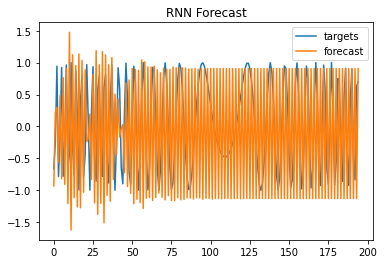

In [15]:
#Forecasting future value
forecast = []
input_ = X[N//2]
while len(forecast) < len(Y[N//2:]):
  # Reshape the input_ to N x T x D
  f = model.predict(input_.reshape(1, T, 1))[0,0]
  forecast.append(f)

  # make a new input with the latest forecast
  input_ = np.roll(input_, -1)
  input_[-1] = f

plt.plot(Y[N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()